# 0. Setup

## 0.1 Install dependencies

In [1]:
! pip install --upgrade pandas --user

    100% |████████████████████████████████| 10.4MB 4.8MB/s eta 0:00:01
Requirement not upgraded as not directly required: python-dateutil>=2.6.1 in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (from pandas) (2.7.3)
Requirement not upgraded as not directly required: numpy>=1.13.3 in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (from pandas) (1.15.4)
Requirement not upgraded as not directly required: pytz>=2017.2 in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (from pandas) (2018.4)
Requirement not upgraded as not directly required: six>=1.5 in /home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages (from python-dateutil>=2.6.1->pandas) (1.11.0)
fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
Cache entry deserialization failed, entry ignored
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [10]:
! pip install wordcloud

    100% |████████████████████████████████| 368kB 9.8MB/s eta 0:00:01
fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
! pip install kaggle

    100% |████████████████████████████████| 61kB 2.7MB/s ta 0:00:011
    100% |████████████████████████████████| 81kB 3.9MB/s ta 0:00:011
  Running setup.py bdist_wheel for kaggle ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674
  Running setup.py bdist_wheel for python-slugify ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/11/94/81/312969455540cb0e6a773e5d68a73c14128bfdfd4a7969bb4f
Successfully built kaggle python-slugify
fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
! pip install fasttext

    100% |████████████████████████████████| 61kB 2.7MB/s ta 0:00:011
  Running setup.py bdist_wheel for fasttext ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/9f/f0/04/caa82c912aee89ce76358ff954f3f0729b7577c8ff23a292e3
Successfully built fasttext
fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## 0.2 Import required modules

In [1]:
import string
import re 
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
import csv
import multiprocessing
from multiprocessing import Pool
import nltk

We need pandas 0.25 since we are going to use the *explode* method for DataFrames later.

In [3]:
print(pd.__version__)

0.25.3


# 1. Downloading the data

Create */home/ec2-user/.kaggle* directory and copy **kaggle.json** file to it.

In [4]:
! mkdir /home/ec2-user/.kaggle/

In [5]:
! cp kaggle.json /home/ec2-user/.kaggle/kaggle.json

Change permissions to the **kaggle.json** file (so the owner can read and write).

In [6]:
! chmod 600 /home/ec2-user/.kaggle/kaggle.json

Download dataset using kaggle CLI tool. A *stacksample.zip* file will be downloaded to the current directory.

In [7]:
! kaggle datasets download stackoverflow/stacksample

100%|█████████████████████████████████████▉| 1.11G/1.11G [00:39<00:00, 31.4MB/s]
100%|██████████████████████████████████████| 1.11G/1.11G [00:39<00:00, 30.2MB/s]


Create a new directory called *stacksample* and unzip both Questions and Tags csv files inside of it.

In [8]:
! mkdir stacksample

In [9]:
! unzip -j stacksample.zip Questions.csv -d stacksample/

Archive:  stacksample.zip
  inflating: stacksample/Questions.csv  


In [10]:
! unzip -j stacksample.zip Tags.csv -d stacksample/

Archive:  stacksample.zip
  inflating: stacksample/Tags.csv    


Delete the stacksample.zip file and create directories where we are going to store processed train, validation and test data for BlazingText and PyTorch models.

In [11]:
! rm stacksample.zip

In [12]:
! mkdir forBlazingText forPyTorch

# 2. Preparing the data

We begin by loading the data (both the Questions and Tags tables) by chunks. We have followed the same approach as in [Yi Ai's](https://medium.com/@yia333) [Medium post](https://medium.com/hackernoon/auto-generating-tags-for-content-using-amazon-sagemaker-blazingtext-with-fasttext-335c38429de0).

In [3]:
QuestionsFile = "stacksample/Questions.csv"
chunksize = 20000

df = None
for ratings in pd.read_csv(QuestionsFile, names=['id', 'title', 'body'], encoding = 'ISO-8859-1',  header=None , usecols=[0,5,6],error_bad_lines = False, chunksize=chunksize):
    if df is None:
        df = ratings.copy()
    else:
        df.append(ratings)
        
TagsFile = "stacksample/Tags.csv"
chunksize = 20000
df_tags = None
for ratings in pd.read_csv(TagsFile, names=['id', 'tag'], header=None , chunksize=chunksize):
    if df_tags is None:
        df_tags = ratings.copy()
    else:
        df_tags.append(ratings)

# 3. Data Exploration & Visualization

Let's compute statistics over the frequency counts of the *tag* field in the tags dataframe.

In [91]:
df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).to_frame().describe()

,tag
count,3506.000000
mean,5.702510
std,27.213578
min,1.000000
25%,1.000000
50%,1.000000
75%,3.000000
max,862.000000


Let's plot a histogram over the top-100 most frequent tags.

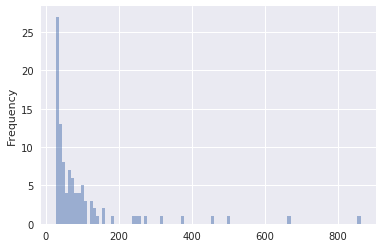

In [87]:
df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).head(100).plot.hist(bins=100, alpha=0.5)

Create a dataframe with tags and frequency counts with the top-100 most frequent tags.

In [34]:
mytags = df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).to_frame().head(100).reset_index()

Let's compute statistics as before, for the subset of the top-100 most frequent tags.

In [86]:
mytags.describe()

,tag
count,100.000000
mean,99.230000
std,128.606506
min,29.000000
25%,37.000000
50%,56.000000
75%,98.250000
max,862.000000


### Wordcloud of the top-100 most frequent tags

In [36]:
d = {}
for a, x in mytags.values:
    d[a] = x

In [38]:
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black').generate_from_frequencies(frequencies=d)

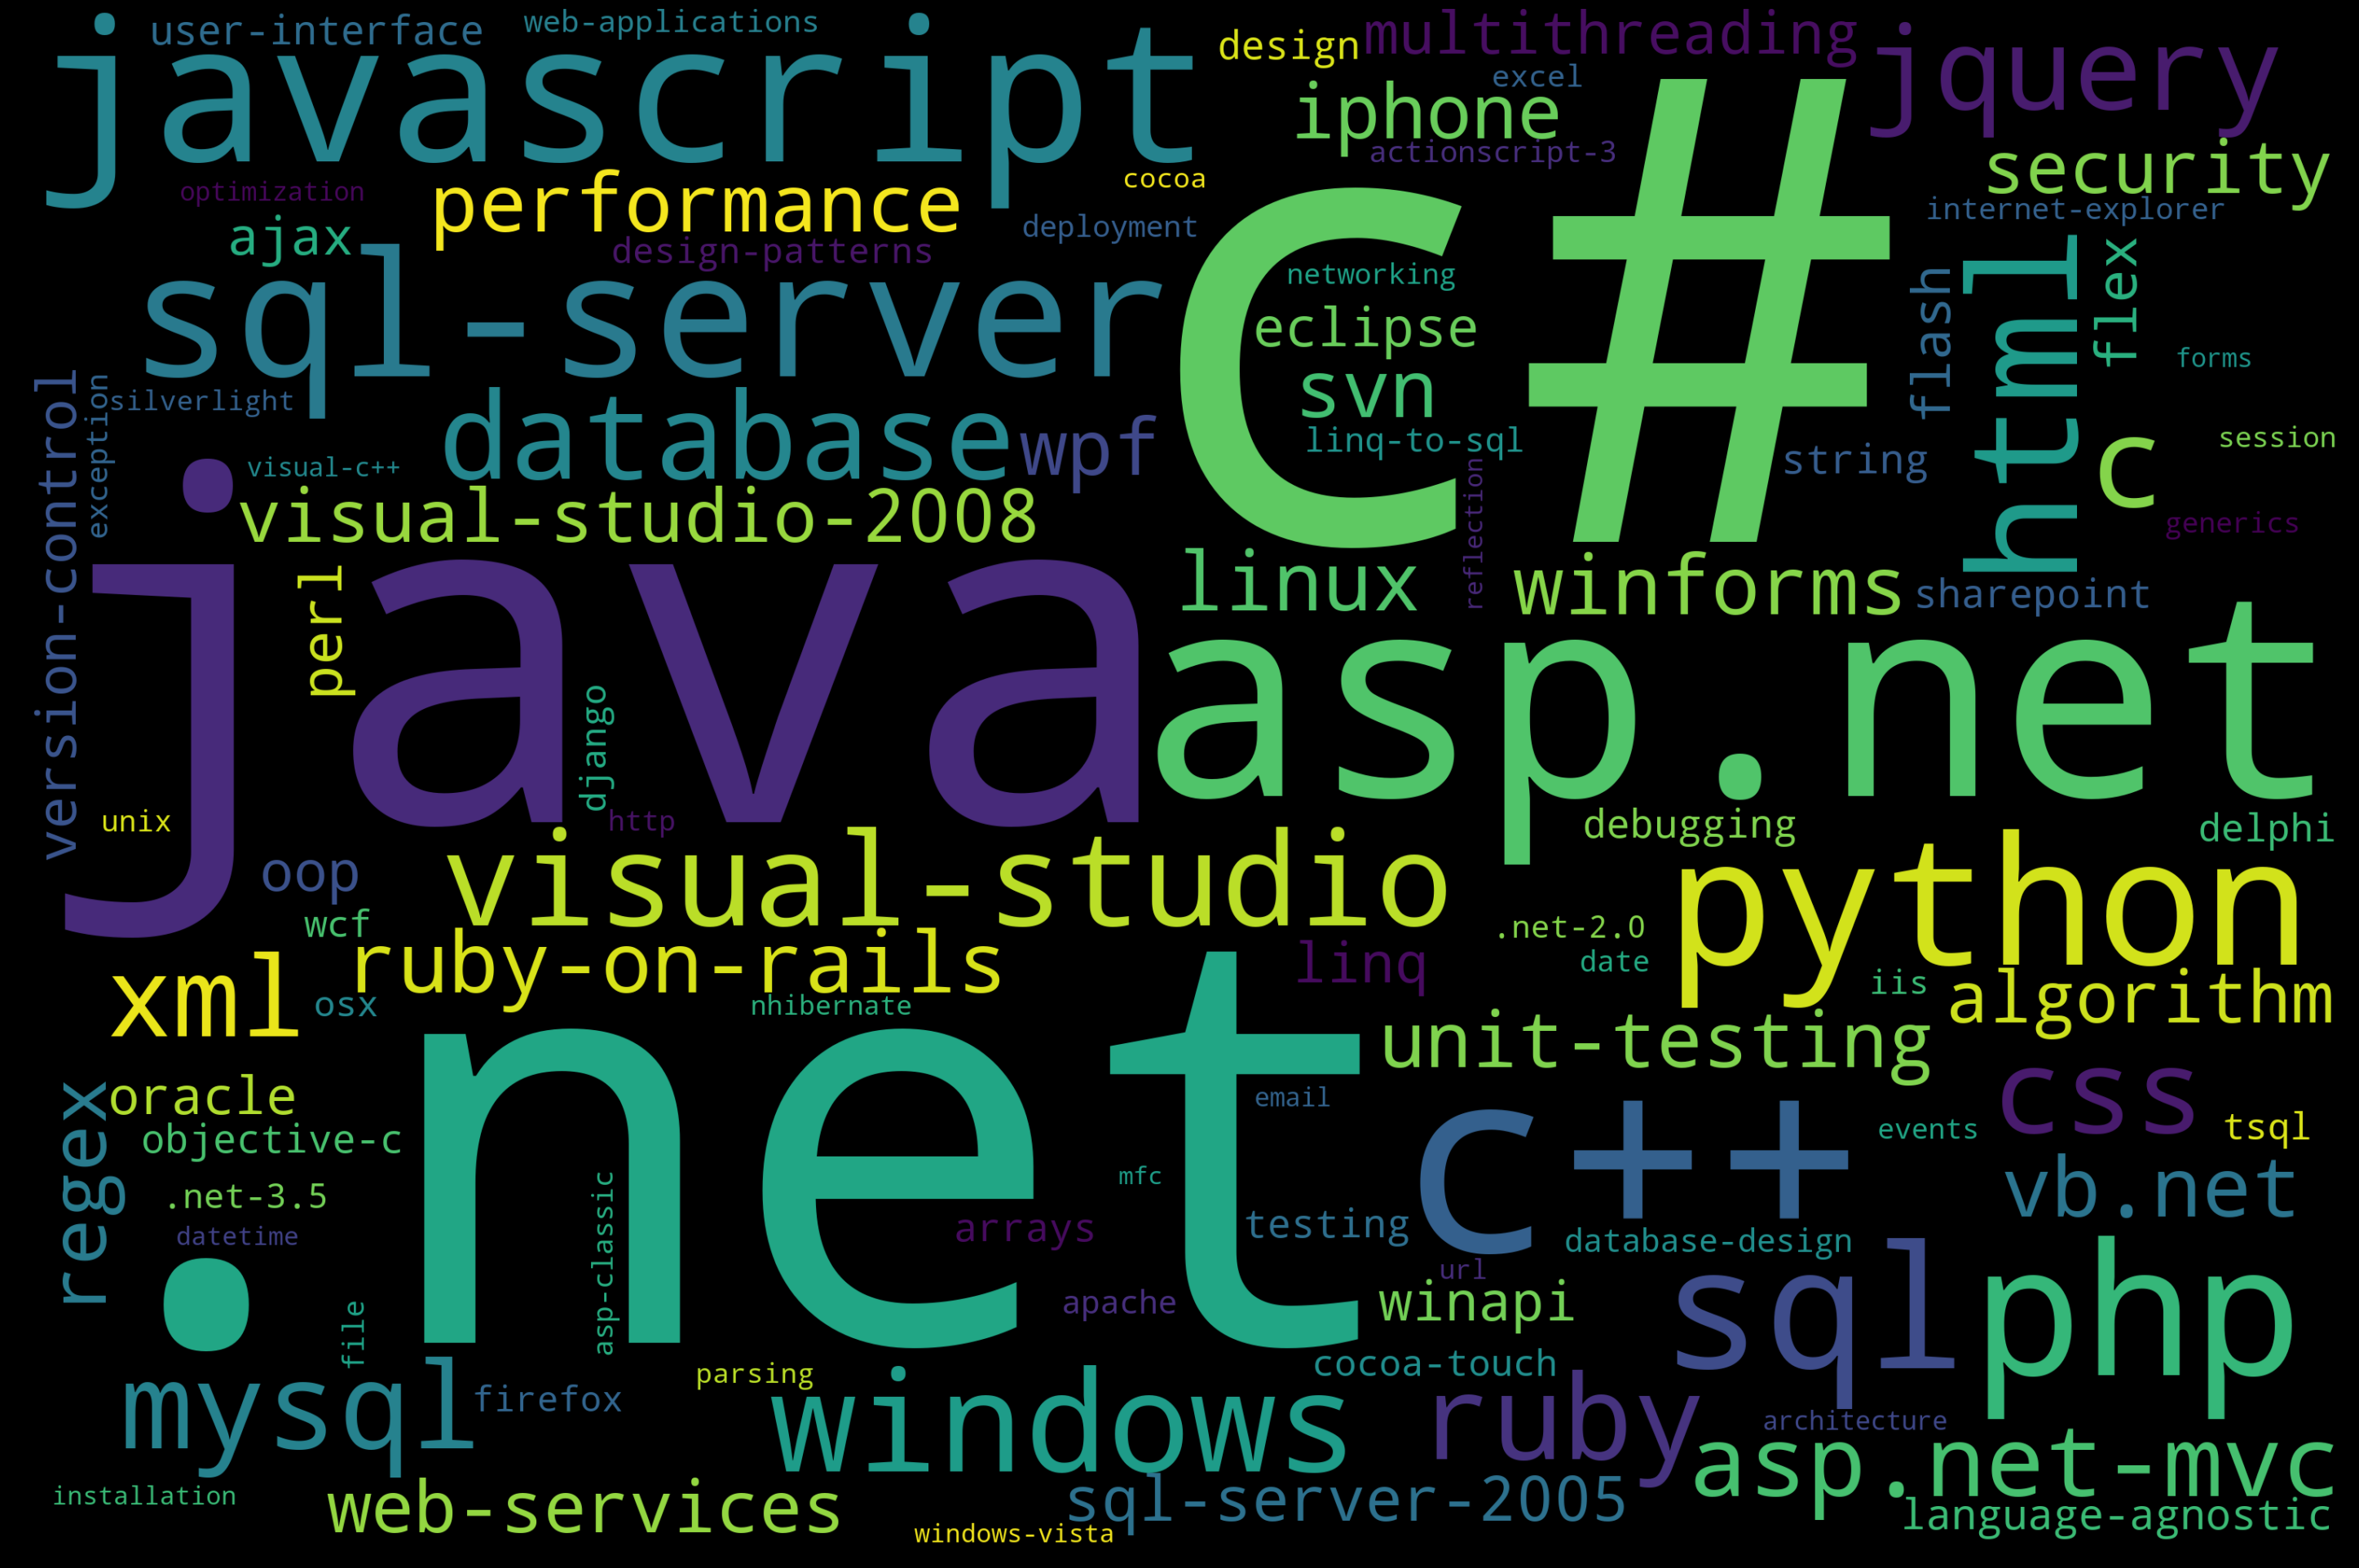

In [56]:
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()
fig.savefig('toptags.png', dpi=fig.dpi)

Let's store the top-100 most frequent tags in a list.

In [95]:
topTags = df_tags.tag.value_counts(normalize=False,sort=True,ascending=False).head(100).index.tolist()

Let's filter the tags dataframe based on the previous list.

In [97]:
df_tags = df_tags[df_tags.tag.isin(topTags)]

# 4. Processing the data

For both fastText and BlazingText, the input file has to be formatted in a way that each line contain a single sentence and the corresponding label(s) prefixed by __label__, e.g.  ``__label__database __label__oracle How to edit sessions parameters on Oracle 10g XE?``. Additionally, the input data has to be as clean as possible. The following function generates a preprocessed and clean data after removing HTML tags and unwanted punctuations. 

For both steps, we have followed the same approach as in [Yi Ai's](https://medium.com/@yia333) [Medium post](https://medium.com/hackernoon/auto-generating-tags-for-content-using-amazon-sagemaker-blazingtext-with-fasttext-335c38429de0). The following functions perform the aforementioned steps.

In [2]:
def clean_text(text):
    if not isinstance(text, str): 
        return text
    def cleanhtml(raw_html):
        cleanr = re.compile('<[^>]+>')
        cleantext = re.sub(cleanr, '', raw_html)
        return cleantext
    def replace_link(match):
        return '' if re.match('[a-z]+://', match.group(1)) else match.group(1)
    def removeContractions(raw_text):
        CONTRACTIONS = {"mayn't":"may not", "may've":"may have","isn't":"is not","wasn't":"was not","'ll":" will","'have": "have"}
        raw_text = raw_text.replace("’","'")
        words = raw_text.split()
        reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words]
        raw_text = " ".join(reformed)
        return raw_text
    text = cleanhtml(text)
    #text = removeContractions(text)
    text = re.sub('<pre><code>.*?</code></pre>', '', text)
    text = re.sub('<a[^>]+>(.*)</a>', replace_link, text)
    #Remove hashtags
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", text).split())
    #Remove punctuations
    text = ' '.join(re.sub("[\.\,\(\)\{\}\[\]\`\'\!\?\:\;\-\=]", " ", text).split())
    #text = text.translate(str.maketrans('','',string.punctuation))
    #text = text.lower()
    return text

In [17]:
questions = df.values
tags = df_tags.values

all_rows=[]

for index, row in enumerate(questions):
    title = clean_text(row[1])
    tag_ids = [ tag[1] for tag_idx, tag in enumerate(tags) if tag[0]  == row[0] ]
    if(len(tag_ids)>0): 
        all_rows.append({"title":title, "tags":tag_ids})

In [18]:
nltk.download('punkt')

def preprocess(rows,output_file):
    pool = Pool(processes=multiprocessing.cpu_count())
    transformed_rows = pool.map(transform_instance, rows)
    pool.close() 
    pool.join()
    with open(output_file, "w") as txt_file:
        for line in transformed_rows:
            txt_file.write(" ".join(line) + "\n")
            
def transform_instance(row):
    cur_row = []
    label = ["__label__" + str(tag) for tag in row["tags"] if tag]
    label = " ".join(map(str, label))
    cur_row.append(str(label))
    cur_row.extend(nltk.word_tokenize(row["title"]))
    return cur_row

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# 5. Create training, validation and test sets and store them in local directory

## For fastText and BlazingText models

Apply the previous defined functions and split the data pseudorandomly on train, validation and test sets.

In [19]:
train, valid = train_test_split(all_rows,test_size=0.20,random_state=45763)
valid, test = train_test_split(valid,test_size=0.50,random_state=45763)

preprocess(train, 'forBlazingText/train')    
preprocess(valid, 'forBlazingText/valid')
preprocess(test, 'forBlazingText/test')

## For PyTorch model

In the case of the PyTorch's LSTM network, in order to simplify the choice and engineering of the network architecture and/or the loss function, and inspired by a fastText [issue discussion](https://github.com/facebookresearch/fastText/issues/72), we had the idea to train the LSTM network like a traditional single-label classification one, using the same input text multiple times with their different labels each time at training time. In order to accomplish this, we need to take the previous train, validation, and test data, and *explode* the column that contains the tags for each sample.

In [20]:
pdf_train = pd.DataFrame(train).explode('tags')
pdf_valid = pd.DataFrame(valid).explode('tags')
pdf_test = pd.DataFrame(test).explode('tags')

pdf_train.to_csv("./forPyTorch/train.csv",sep=",",header=True,index=False)
pdf_valid.to_csv("./forPyTorch/valid.csv",sep=",",header=True,index=False)
pdf_test.to_csv("./forPyTorch/test.csv",sep=",",header=True,index=False)

# 6. Building and Training the Models

Before training and using the models for predictions, let's take our test set and make a list with the true tags for each instance in the set. We are going to collect predictions for each model and append a new column to this dataframe with the corresponding predictions each time.

In [21]:
grouped = pdf_test.groupby('title').apply(lambda x: list(x.tags)).reset_index().rename(columns={0: "true"})

Let's take a small sample. This will be our working sample to show predictions for each model from now on.

In [22]:
grouped.sample(10,random_state=45763)

,title,true
415,Rendered pIxel width data for each character i...,"[javascript, jquery, html, css]"
349,MVC architecture question for Mac application,"[objective-c, cocoa, osx]"
178,How could I get my SVN only host to pull from ...,[svn]
53,C# vs Java generics,"[c#, java, generics]"
361,NET Runtime 2 0 Error in a service,"[.net, asp.net, .net-3.5, .net-2.0]"
279,Implement validation as a method or as a property,[c#]
354,Migrating Java UNO code from OpenOffice 2 4 to...,[java]
174,How can I retrieve an assembly s qualified typ...,"[c#, asp.net]"
561,asp net sql timeout when not using sql,"[c#, asp.net, sql-server]"
92,"Dealing with C++ ""initialized but not referenc...",[c++]


## 6.1 fastText

For the fastText model to use as baseline, we use the same settings as reported in [Yi Ai's](https://medium.com/@yia333) [Medium post](https://medium.com/hackernoon/auto-generating-tags-for-content-using-amazon-sagemaker-blazingtext-with-fasttext-335c38429de0). In this case, for quick training and predicting, we can use the data stored locally and use fastText locally. Note that if we would like to deploy the model for predictions via Amazon SageMaker and BlazingText, we can do in the same way he reports in the post.

Train the fastText model in local mode.

In [23]:
import fasttext
ft_model = fasttext.train_supervised(input="forBlazingText/train", lr=0.5, epoch=25, wordNgrams=2,dim=100)

Note that we can compute average *precision@k* and *recall@k* over the test set using fastText built-in tool for metrics.

In [24]:
ft_model.test("forBlazingText/test",k=3)

(592, 0.2905405405405405, 0.5180722891566265)

Let's define a function to perform predictions and get the top-3 most probable tags for each instance of the test set.

In [25]:
def get_FTpredictions(sentence):
    predictions = ft_model.predict(sentence,k=3)[0]
    output = [element.replace("__label__","") for element in predictions]
    return output

Apply the previous function over the *title* field in the test set.

In [26]:
grouped['ft_predictions'] = grouped.title.apply(get_FTpredictions)

Let's take a look to predictions on our small sample.

In [27]:
grouped.sample(10,random_state=45763)

,title,true,ft_predictions
415,Rendered pIxel width data for each character i...,"[javascript, jquery, html, css]","[javascript, xml, python]"
349,MVC architecture question for Mac application,"[objective-c, cocoa, osx]","[flex, networking, actionscript-3]"
178,How could I get my SVN only host to pull from ...,[svn],"[svn, delphi, version-control]"
53,C# vs Java generics,"[c#, java, generics]","[java, networking, security]"
361,NET Runtime 2 0 Error in a service,"[.net, asp.net, .net-3.5, .net-2.0]","[.net, winforms, c#]"
279,Implement validation as a method or as a property,[c#],"[c#, python, .net]"
354,Migrating Java UNO code from OpenOffice 2 4 to...,[java],"[java, eclipse, web-services]"
174,How can I retrieve an assembly s qualified typ...,"[c#, asp.net]","[.net, c#, exception]"
561,asp net sql timeout when not using sql,"[c#, asp.net, sql-server]","[asp.net, c#, sql-server]"
92,"Dealing with C++ ""initialized but not referenc...",[c++],"[c++, javascript, c#]"


## 6.2 BlazingText

In [28]:
import sagemaker
from sagemaker import get_execution_role
import boto3
import json

sess = sagemaker.Session()
role = get_execution_role()
print(role) 
bucket = sess.default_bucket()
print(bucket)
prefix = 'capstone/blazingText'

arn:aws:iam::201513274994:role/service-role/AmazonSageMaker-ExecutionRole-20191123T191960
sagemaker-us-east-2-201513274994


### Upload training and validation data to S3

In [29]:
train_channel = prefix + '/train'
valid_channel = prefix + '/validation'

sess.upload_data(path='forBlazingText/train', bucket=bucket, key_prefix=train_channel)
sess.upload_data(path='forBlazingText/valid', bucket=bucket, key_prefix=valid_channel)

s3_train_data = 's3://{}/{}'.format(bucket, train_channel)
s3_valid_data = 's3://{}/{}'.format(bucket, valid_channel)

In [30]:
s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
region_name = boto3.Session().region_name
container = sagemaker.amazon.amazon_estimator.get_image_uri(region_name, "blazingtext", "latest")
print('Using SageMaker BlazingText container: {} ({})'.format(container, region_name))

Using SageMaker BlazingText container: 825641698319.dkr.ecr.us-east-2.amazonaws.com/blazingtext:latest (us-east-2)


### Setting and training the model

In [31]:
bt_model = sagemaker.estimator.Estimator(container,
                                         role, 
                                         train_instance_count=1, 
                                         train_instance_type='ml.c4.4xlarge',
                                         train_volume_size = 30,
                                         train_max_run = 360000,
                                         input_mode= 'File',
                                         output_path=s3_output_location,
                                         sagemaker_session=sess)

bt_model.set_hyperparameters(mode="supervised",
                            epochs=25,
                            min_count=5,
                            learning_rate=0.5,
                            vector_dim=100,
                            early_stopping=True,
                            patience=5,
                            min_epochs=5,
                            word_ngrams=2)

train_data = sagemaker.session.s3_input(s3_train_data, distribution='FullyReplicated', 
                        content_type='text/plain', s3_data_type='S3Prefix')
valid_data = sagemaker.session.s3_input(s3_valid_data, distribution='FullyReplicated', 
                             content_type='text/plain', s3_data_type='S3Prefix')
data_channels = {'train': train_data, 'validation': valid_data}

In [32]:
bt_model.fit(inputs=data_channels, logs=True)

2019-12-20 22:34:24 Starting - Starting the training job...
2019-12-20 22:34:26 Starting - Launching requested ML instances......
2019-12-20 22:35:50 Starting - Preparing the instances for training......
2019-12-20 22:36:47 Downloading - Downloading input data...
2019-12-20 22:37:14 Training - Training image download completed. Training in progress.Arguments: train
[12/20/2019 22:37:15 WARNING 140256981219136] Loggers have already been setup.
[12/20/2019 22:37:15 WARNING 140256981219136] Loggers have already been setup.
[12/20/2019 22:37:15 INFO 140256981219136] nvidia-smi took: 0.02516913414 secs to identify 0 gpus
[12/20/2019 22:37:15 INFO 140256981219136] Running single machine CPU BlazingText training using supervised mode.
[12/20/2019 22:37:15 INFO 140256981219136] Processing /opt/ml/input/data/train/train . File size: 0 MB
[12/20/2019 22:37:15 INFO 140256981219136] Processing /opt/ml/input/data/validation/valid . File size: 0 MB
Read 0M words
Number of words:  1236
Loading valida

### Deploy and use the model for testing

In [33]:
bt_4deploy = sagemaker.Model(model_data=bt_model.model_data, image=container, role=role, sagemaker_session=sess)
bt_4deploy.deploy(initial_instance_count = 1,instance_type = 'ml.m4.xlarge')
bt_predictor = sagemaker.RealTimePredictor(endpoint=bt_4deploy.endpoint_name, 
                                   sagemaker_session=sess,
                                   serializer=json.dumps,
                                   deserializer=sagemaker.predictor.json_deserializer)

--------------------------------------------------------------------------------------!

Let's define a function to perform predictions and get the top-3 most probable tags for each instance of the test set.

In [34]:
def get_BTpredictions(sentence):
    payload = {"instances" : [sentence],"configuration": {"k":3}}
    predictions = bt_predictor.predict(payload)
    predictions = predictions[0]['label']
    output = [prediction.replace('__label__', '') for prediction in predictions]
    return output

Apply the previous function over the *title* field in the test set.

In [35]:
grouped['bt_predictions'] = grouped.title.apply(get_BTpredictions)

Let's take a look to predictions on our small sample.

In [36]:
grouped.sample(10,random_state=45763)

,title,true,ft_predictions,bt_predictions
415,Rendered pIxel width data for each character i...,"[javascript, jquery, html, css]","[javascript, xml, python]","[xml, javascript, java]"
349,MVC architecture question for Mac application,"[objective-c, cocoa, osx]","[flex, networking, actionscript-3]","[objective-c, flex, architecture]"
178,How could I get my SVN only host to pull from ...,[svn],"[svn, delphi, version-control]","[svn, delphi, ajax]"
53,C# vs Java generics,"[c#, java, generics]","[java, networking, security]","[java, networking, exception]"
361,NET Runtime 2 0 Error in a service,"[.net, asp.net, .net-3.5, .net-2.0]","[.net, winforms, c#]","[.net, c#, .net-2.0]"
279,Implement validation as a method or as a property,[c#],"[c#, python, .net]","[.net, c#, python]"
354,Migrating Java UNO code from OpenOffice 2 4 to...,[java],"[java, eclipse, web-services]","[java, eclipse, javascript]"
174,How can I retrieve an assembly s qualified typ...,"[c#, asp.net]","[.net, c#, exception]","[c#, .net, reflection]"
561,asp net sql timeout when not using sql,"[c#, asp.net, sql-server]","[asp.net, c#, sql-server]","[asp.net, sql-server, sql]"
92,"Dealing with C++ ""initialized but not referenc...",[c++],"[c++, javascript, c#]","[c++, c#, javascript]"


## 6.3 PyTorch

### Upload training and validation data to S3

In [37]:
sagemaker_session = sagemaker.Session()
data_dir = 'forPyTorch'
prefix = 'capstone/PyTorch'
# upload to S3
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-us-east-2-201513274994/capstone/PyTorch


### Setting and training the model

In [38]:
from sagemaker.pytorch import PyTorch

# specify an output path
# prefix is specified above
output_path = 's3://{}/{}'.format(bucket, prefix)

pt_model = PyTorch(entry_point='train.py',
                    source_dir='source', # this should be just "source" for your code
                    role=role,
                    framework_version='1.0',
                    train_instance_count=1,
                    train_instance_type='ml.p2.xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'epochs': 20,
                        'embedding_dim': 100,  
                        'hidden_dim': 32,
                        'n_layers': 2,
                        'dropout': 0.5,
                        'padding_idx': 1,
                    })

In [39]:
pt_model.fit({'train': input_data})

2019-12-20 22:49:52 Starting - Starting the training job...
2019-12-20 22:49:53 Starting - Launching requested ML instances...
2019-12-20 22:50:50 Starting - Preparing the instances for training.........
2019-12-20 22:52:03 Downloading - Downloading input data...
2019-12-20 22:52:27 Training - Downloading the training image...
2019-12-20 22:53:12 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2019-12-20 22:53:13,170 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2019-12-20 22:53:13,196 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2019-12-20 22:53:16,219 sagemaker_pytorch_container.training INFO     Invoking user training script.
2019-12-20 22:53:16,487 sagemaker-containers INFO     Module train does not provide a setup.py. 
Generating setup.py
2019-12-20 22:53:16,487 sagemake

### Deploy and use the model for testing

In [40]:
from sagemaker.predictor import RealTimePredictor
from sagemaker.pytorch import PyTorchModel

class StringPredictor(RealTimePredictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(StringPredictor, self).__init__(endpoint_name, sagemaker_session, content_type='text/plain')

In [41]:
pt_4deploy = PyTorchModel(model_data=pt_model.model_data,
                     role = role,
                     framework_version='1.0',
                     entry_point='predict.py',
                     source_dir='source',
                     predictor_cls=StringPredictor)

pt_predictor = pt_4deploy.deploy(initial_instance_count=1, instance_type='ml.m4.xlarge')

--------------------------------------------------------------------------------------!

Let's define a function to perform predictions and get the top-3 most probable tags for each instance of the test set.

In [42]:
def get_PTpredictions(sentence):
    predictions = pt_predictor.predict(sentence).decode("utf-8").strip('][').split(', ') 
    output = [prediction.replace("'", '') for prediction in predictions]
    return output

Apply the previous function over the *title* field in the test set.

In [43]:
grouped['pt_predictions'] = grouped.title.apply(get_PTpredictions)

Let's take a look to predictions on our small sample.

In [44]:
grouped.sample(10,random_state=45763)

,title,true,ft_predictions,bt_predictions,pt_predictions
415,Rendered pIxel width data for each character i...,"[javascript, jquery, html, css]","[javascript, xml, python]","[xml, javascript, java]","[algorithm, c#, .net]"
349,MVC architecture question for Mac application,"[objective-c, cocoa, osx]","[flex, networking, actionscript-3]","[objective-c, flex, architecture]","[design-patterns, wpf, user-interface]"
178,How could I get my SVN only host to pull from ...,[svn],"[svn, delphi, version-control]","[svn, delphi, ajax]","[.net, delphi, nhibernate]"
53,C# vs Java generics,"[c#, java, generics]","[java, networking, security]","[java, networking, exception]","[java, c#, c++]"
361,NET Runtime 2 0 Error in a service,"[.net, asp.net, .net-3.5, .net-2.0]","[.net, winforms, c#]","[.net, c#, .net-2.0]","[asp.net-mvc, c#, asp.net]"
279,Implement validation as a method or as a property,[c#],"[c#, python, .net]","[.net, c#, python]","[.net, c#, xml]"
354,Migrating Java UNO code from OpenOffice 2 4 to...,[java],"[java, eclipse, web-services]","[java, eclipse, javascript]","[unit-testing, java, c#]"
174,How can I retrieve an assembly s qualified typ...,"[c#, asp.net]","[.net, c#, exception]","[c#, .net, reflection]","[.net, c#, vb.net]"
561,asp net sql timeout when not using sql,"[c#, asp.net, sql-server]","[asp.net, c#, sql-server]","[asp.net, sql-server, sql]","[javascript, asp.net, jquery]"
92,"Dealing with C++ ""initialized but not referenc...",[c++],"[c++, javascript, c#]","[c++, c#, javascript]","[c#, c++, .net]"


# 7. Model evaluation 

Let's create functions to compute *precision@3* and *recall@k'*, where *k'* is the number of true tags for a particular sample. We are going to apply these functions to compute the aforementioned metrics sample-wise so we can compute statistics later.

In [45]:
def samplewiseRecall(predictions,true):
    recall = len(set(predictions).intersection(set(true)))/len(set(true))
    return recall

def samplewisePrecision(predictions,true):
    precision = len(set(predictions).intersection(set(true)))/len(set(predictions))
    return precision

Apply the previous functions to compute metrics using the true tags and predicted tags, for each model predictions.

In [46]:
grouped['ft_recall'] = np.vectorize(samplewiseRecall)(grouped['ft_predictions'], grouped['true'])
grouped['bt_recall'] = np.vectorize(samplewiseRecall)(grouped['bt_predictions'], grouped['true'])
grouped['pt_recall'] = np.vectorize(samplewiseRecall)(grouped['pt_predictions'], grouped['true'])

In [47]:
grouped['ft_precision'] = np.vectorize(samplewisePrecision)(grouped['ft_predictions'], grouped['true'])
grouped['bt_precision'] = np.vectorize(samplewisePrecision)(grouped['bt_predictions'], grouped['true'])
grouped['pt_precision'] = np.vectorize(samplewisePrecision)(grouped['pt_predictions'], grouped['true'])

Compute statistics of the metrics.

In [48]:
grouped.describe()

,ft_recall,bt_recall,pt_recall,ft_precision,bt_precision,pt_precision
count,592.000000,592.000000,592.000000,592.000000,592.000000,592.000000
mean,0.548958,0.546847,0.463514,0.280405,0.276464,0.240428
std,0.428335,0.429380,0.428909,0.222395,0.219285,0.223212
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.500000,0.500000,0.333333,0.333333,0.333333
75%,1.000000,1.000000,1.000000,0.333333,0.333333,0.333333
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Let's take a look to a bigger sample to inspect some qualitative results and comparisons.

In [49]:
pd.options.display.max_rows = 30
grouped.sample(30,random_state=45763)

,title,true,ft_predictions,bt_predictions,pt_predictions,ft_recall,bt_recall,pt_recall,ft_precision,bt_precision,pt_precision
415,Rendered pIxel width data for each character i...,"[javascript, jquery, html, css]","[javascript, xml, python]","[xml, javascript, java]","[algorithm, c#, .net]",0.250000,0.250000,0.000000,0.333333,0.333333,0.000000
349,MVC architecture question for Mac application,"[objective-c, cocoa, osx]","[flex, networking, actionscript-3]","[objective-c, flex, architecture]","[design-patterns, wpf, user-interface]",0.000000,0.333333,0.000000,0.000000,0.333333,0.000000
178,How could I get my SVN only host to pull from ...,[svn],"[svn, delphi, version-control]","[svn, delphi, ajax]","[.net, delphi, nhibernate]",1.000000,1.000000,0.000000,0.333333,0.333333,0.000000
53,C# vs Java generics,"[c#, java, generics]","[java, networking, security]","[java, networking, exception]","[java, c#, c++]",0.333333,0.333333,0.666667,0.333333,0.333333,0.666667
361,NET Runtime 2 0 Error in a service,"[.net, asp.net, .net-3.5, .net-2.0]","[.net, winforms, c#]","[.net, c#, .net-2.0]","[asp.net-mvc, c#, asp.net]",0.250000,0.500000,0.250000,0.333333,0.666667,0.333333
279,Implement validation as a method or as a property,[c#],"[c#, python, .net]","[.net, c#, python]","[.net, c#, xml]",1.000000,1.000000,1.000000,0.333333,0.333333,0.333333
354,Migrating Java UNO code from OpenOffice 2 4 to...,[java],"[java, eclipse, web-services]","[java, eclipse, javascript]","[unit-testing, java, c#]",1.000000,1.000000,1.000000,0.333333,0.333333,0.333333
174,How can I retrieve an assembly s qualified typ...,"[c#, asp.net]","[.net, c#, exception]","[c#, .net, reflection]","[.net, c#, vb.net]",0.500000,0.500000,0.500000,0.333333,0.333333,0.333333
561,asp net sql timeout when not using sql,"[c#, asp.net, sql-server]","[asp.net, c#, sql-server]","[asp.net, sql-server, sql]","[javascript, asp.net, jquery]",1.000000,0.666667,0.333333,1.000000,0.666667,0.333333
92,"Dealing with C++ ""initialized but not referenc...",[c++],"[c++, javascript, c#]","[c++, c#, javascript]","[c#, c++, .net]",1.000000,1.000000,1.000000,0.333333,0.333333,0.333333


# 8. Use a model for the web app

We choose to use the PyTorch based model for the web app. We can do this in the standard way, using a Lambda function and an API.

Get the name of the endpoint corresponding to our PyTorch model.

In [53]:
print(pt_predictor.endpoint)

sagemaker-pytorch-2019-12-20-22-55-44-590


Our Lambda function looks like this. Note that we are calling our endpoint via its name, printed before.

```python
import boto3

def lambda_handler(event, context):

    # The SageMaker runtime is what allows us to invoke the endpoint that we've created.
    runtime = boto3.Session().client('sagemaker-runtime')

    # Now we use the SageMaker runtime to invoke our endpoint, sending the review we were given
    response = runtime.invoke_endpoint(EndpointName = 'sagemaker-pytorch-2019-12-20-22-55-44-590',    # The name of the endpoint we created
                                       ContentType = 'text/plain',                 # The data format that is expected
                                       Body = event['body'])                       # The actual input question text

    # The response is an HTTP response whose body contains the result of our inference
    result = response['Body'].read().decode('utf-8')

    return {
        'statusCode' : 200,
        'headers' : { 'Content-Type' : 'text/plain', 'Access-Control-Allow-Origin' : '*' },
        'body' : result
    }
```

After we have set up our Lambda function via AWS Lambda and an API via API Gateway, we can use a HTML template to call our API. Our HTML file looks like this. Note that we are calling our API via its public URL (in this case: https://p3q2pfzifl.execute-api.us-east-2.amazonaws.com/capstoneProduction).

```html
<!DOCTYPE html>
<html lang="en">
    <head>
        <title>StackOverflow Auto-Tagging Web App</title>
        <meta charset="utf-8">
        <meta name="viewport"  content="width=device-width, initial-scale=1">
        <link rel="stylesheet" href="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/css/bootstrap.min.css">
        <script src="https://ajax.googleapis.com/ajax/libs/jquery/3.3.1/jquery.min.js"></script>
        <script src="https://maxcdn.bootstrapcdn.com/bootstrap/3.3.7/js/bootstrap.min.js"></script>

        <script>
         "use strict";
         function submitForm(oFormElement) {
             var xhr = new XMLHttpRequest();
             xhr.onload = function() {
                 var result = xhr.responseText;
                 var resultElement = document.getElementById('result');
                 if (result == "0") {
                     resultElement.className = 'bg-danger';
                     resultElement.innerHTML = 'No tags found';
                 } else {
                     resultElement.className = 'bg-success';
                     resultElement.innerHTML = result;
                 }
             }
             xhr.open (oFormElement.method, oFormElement.action, true);
             var review = document.getElementById('review');
             xhr.send (review.value);
             return false;
         }
        </script>

    </head>
    <body>

        <div class="container">
            <h1>Multi-tag prediction</h1>
            <p>Enter your question and get the 3 most probable tags related to it...</p>
            <form method="POST"
                  action="https://p3q2pfzifl.execute-api.us-east-2.amazonaws.com/capstoneProduction"
                  onsubmit="return submitForm(this);" >                     <!-- HERE IS WHERE YOU NEED TO ENTER THE API URL -->
                <div class="form-group">
                    <label for="review">Review:</label>
                    <textarea class="form-control"  rows="5" id="review">Please write your question here.</textarea>
                </div>
                <button type="submit" class="btn btn-default">Submit</button>
            </form>
            <h1 class="bg-success" id="result"></h1>
        </div>
    </body>
</html>
```

As usual, if we open index.html on our local computer, our browser will behave as a local web server and we can use the provided site to interact with our PyTorch model.

### Delete the endpoints we used

In [55]:
bt_predictor.delete_endpoint()

In [56]:
pt_predictor.delete_endpoint()